In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [8]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [9]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
607974               2020-08-30           2020-08-30            2020-08-28   
607975               2020-08-30           2020-08-30            2020-08-29   
607976               2020-08-30           2020-08-30            2020-08-29   
607977               2020-08-30           2020-08-30            2020-08-29   
607978               2020-08-30           2020-08-30            2020-08-29   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
607974                      Asintomáti                   NaT   
607975                      Asintomáti                   NaT   
607976                      Asintomáti                   NaT   
607977                      Asintomáti                   NaT   
607978                      Asintomáti                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento  \
Id de caso                                                            
1                         NaT          Bogotá d.c.      Bogotá D.C.   
2                         NaT  Guadalajara de buga  Valle del Cauca   
3                         NaT             Medellín        Antioquia   
4                         NaT             Medellín        Antioquia   
5                         NaT             Medellín        Antioquia   
...                       ...                  ...              ...   
607974                    NaT          Bogotá d.c.      Bogotá D.C.   
607975                    NaT          Bogotá d.c.      Bogotá D.C.   
607976                    NaT          Bogotá d.c.      Bogotá D.C.   
607977                    NaT          Bogotá d.c.      Bogotá D.C.   
607978                    NaT          Bogotá d.c.      Bogotá D.C.   

               Severidad      Estado  ...  Clasificación de edad Sexo  \
Id de caso                            ...                               
1                   Leve  Recuperado  ...                10 - 20    F   
2                   Leve  Recuperado  ...                30 - 40    M   
3                   Leve  Recuperado  ...                40 - 50    F   
4                   Leve  Recuperado  ...                50 - 60    M   
5                   Leve  Recuperado  ...                20 - 30    M   
...                  ...         ...  ...                    ...  ...   
607974      Asintomático        Casa  ...                40 - 50    M   
607975      Asintomático        Casa  ...                50 - 60    F   
607976      Asintomático        Casa  ...                40 - 50    M   
607977      Asintomático        Casa  ...                50 - 60    M   
607978      Asintomático        Casa  ...                40 - 50    F   

           Pertenecia Étnica Nombre Grupo Étnico         Tipo  \
Id de caso                                                      
1                       Otro                 NaN    Importado   
2                       Otro                 NaN    Importado   
3                       Otro 

### - Casos activos VS Departamento (Estado)

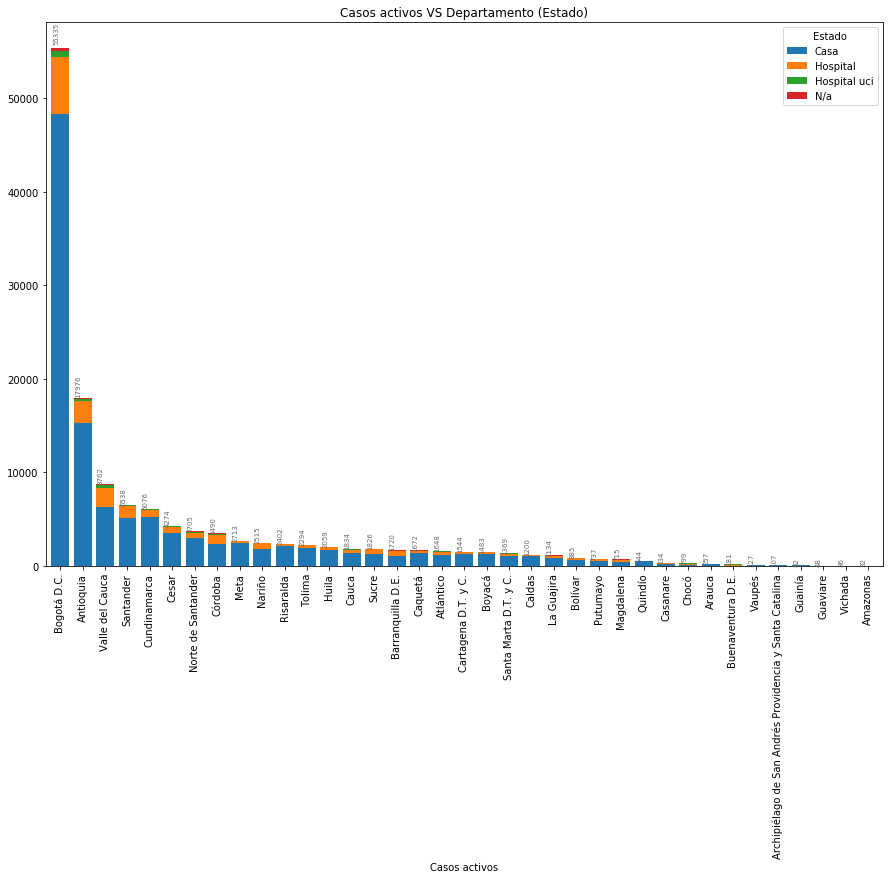

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         48291.0    6161.0   
Antioquia                                           15293.0    2368.0   
Valle del Cauca                                      6314.0    2074.0   
Santander                                            5167.0    1279.0   
Cundinamarca                                         5271.0     746.0   
Cesar                                                3550.0     639.0   
Norte de Santander                                   2978.0     584.0   
Córdoba                                              2393.0     939.0   
Meta                                                 2509.0     174.0   
Nariño                                               1780.0     655.0   
Risaralda                                            2160.0     220.0   
Tolima                                               1951.0     288.0   
Huila                                                1683.0     355.0   
Cauca                                                1366.0     388.0   
Sucre                                                1248.0     533.0   
Barranquilla D.E.                                    1117.0     454.0   
Caquetá                                              1363.0     284.0   
Atlántico                                            1157.0     345.0   
Cartagena D.T. y C.                                  1269.0     198.0   
Boyacá                                               1297.0     158.0   
Santa Marta D.T. y C.                                1076.0     263.0   
Caldas                                               1047.0     129.0   
La Guajira                                            855.0     241.0   
Bolívar                                               697.0     143.0   
Putumayo                                              518.0     206.0   
Magdalena                                             440.0     212.0   
Quindío                                               492.0      48.0   
Casanare                                              272.0      51.0   
Chocó                                                 133.0     136.0   
Arauca                                                237.0      17.0   
Buenaventura D.E.                                      57.0     100.0   
Vaupés                                                120.0       7.0   
Archipiélago de San Andrés Providencia y Santa ...     97.0       9.0   
Guainía                                                80.0       2.0   
Guaviare                                               41.0       5.0   
Vichada                                                34.0       2.0   
Amazonas                                               23.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                556.0  327.0   
Antioquia                                                  208.0  107.0   
Valle del Cauca                                            265.0  109.0   
Santander                                                   65.0   27.0   
Cundinamarca                                                28.0   31.0   
Cesar                                                       67.0   18.0   
Norte de Santander                                         123.0   20.0   
Córdoba                                                     71.0   87.0   
Meta                                                        13.0   17.0   
Nariño                                                      50.0   30.0   
Risaralda                                                   12.0   10.0   
Tolima                                                      25.0   30.0   
Huila                                                       10.0   11.0   
Cauca                      

### - Recuperados y Fallecidos VS Departamento

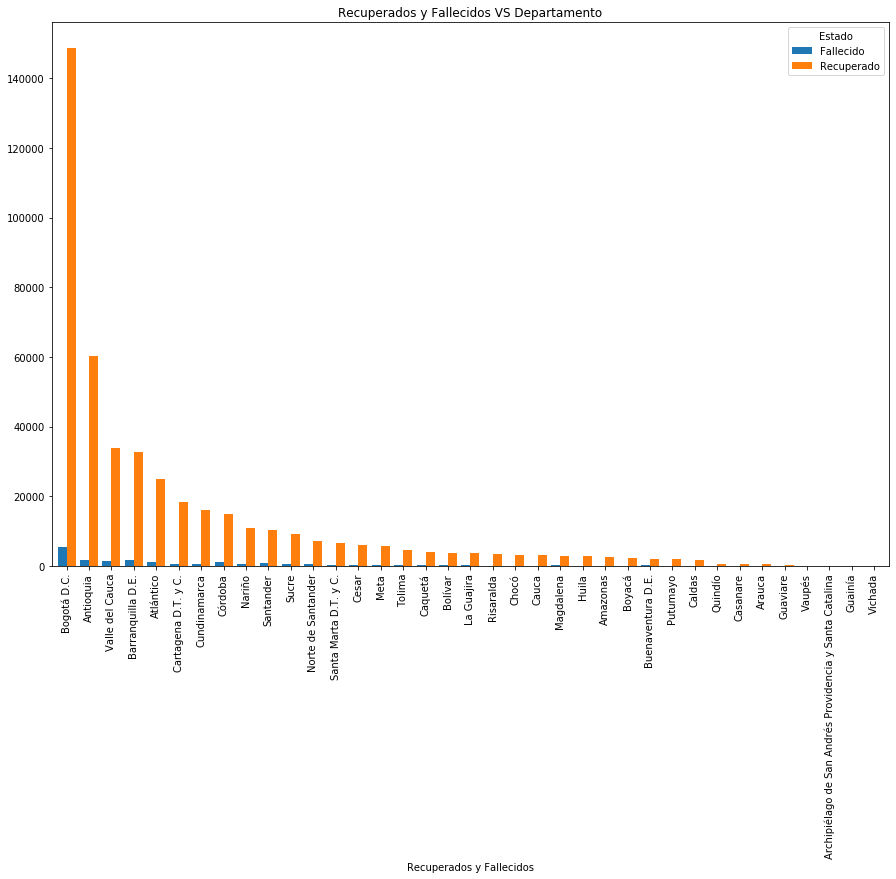

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=('Recuperados y Fallecidos VS Departamento'))
ax.set_xlabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [16]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5375.0    148540.0
Antioquia                                              1652.0     60156.0
Valle del Cauca                                        1573.0     33812.0
Barranquilla D.E.                                      1607.0     32742.0
Atlántico                                              1285.0     25005.0
Cartagena D.T. y C.                                     520.0     18295.0
Cundinamarca                                            640.0     16056.0
Córdoba                                                1261.0     14817.0
Nariño                                                  503.0     10972.0
Santander                                               752.0     10483.0
Sucre                                                   488.0      9310.0
Norte de Santander                                      637.0      7266.0
Santa Marta D.T. y C.                                   349.0      6706.0
Cesar                                                   285.0      5955.0
Meta                                                    191.0      5871.0
Tolima                                                  181.0      4564.0
Caquetá                                                 196.0      3992.0
Bolívar                                                 181.0      3722.0
La Guajira                                              226.0      3664.0
Risaralda                                               105.0      3598.0
Chocó                                                   136.0      3284.0
Cauca                                                   153.0      3260.0
Magdalena                                               328.0      2822.0
Huila                                                   131.0      2817.0
Amazonas                                                109.0      2557.0
Boyacá                                                   73.0      2205.0
Buenaventura D.E.                                       158.0      2063.0
Putumayo                                                132.0      1972.0
Caldas                                                   54.0      1634.0
Quindío                                                  35.0       674.0
Casanare                                                 24.0       671.0
Arauca                                                   17.0       651.0
Guaviare                                                  1.0       216.0
Vaupés                                                    1.0       145.0
Archipiélago de San Andrés Providencia y Santa ...        1.0        90.0
Guainía                                                   2.0        17.0
Vichada                                                   2.0        17.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

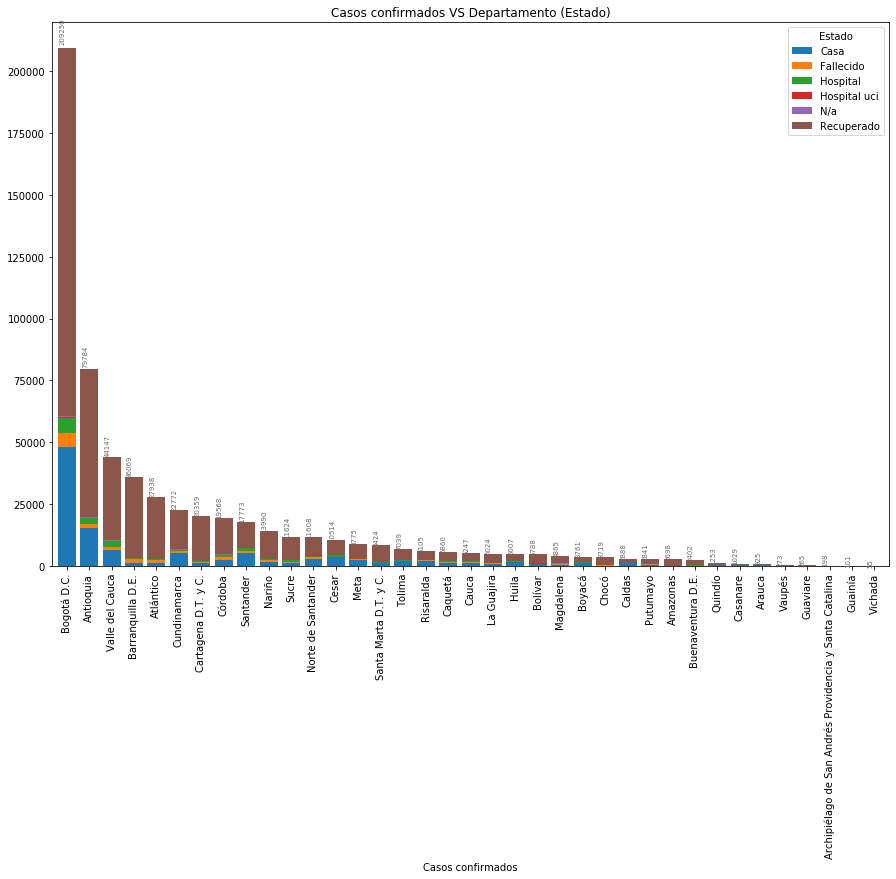

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         48291.0     5375.0   
Antioquia                                           15293.0     1652.0   
Valle del Cauca                                      6314.0     1573.0   
Barranquilla D.E.                                    1117.0     1607.0   
Atlántico                                            1157.0     1285.0   
Cundinamarca                                         5271.0      640.0   
Cartagena D.T. y C.                                  1269.0      520.0   
Córdoba                                              2393.0     1261.0   
Santander                                            5167.0      752.0   
Nariño                                               1780.0      503.0   
Sucre                                                1248.0      488.0   
Norte de Santander                                   2978.0      637.0   
Cesar                                                3550.0      285.0   
Meta                                                 2509.0      191.0   
Santa Marta D.T. y C.                                1076.0      349.0   
Tolima                                               1951.0      181.0   
Risaralda                                            2160.0      105.0   
Caquetá                                              1363.0      196.0   
Cauca                                                1366.0      153.0   
La Guajira                                            855.0      226.0   
Huila                                                1683.0      131.0   
Bolívar                                               697.0      181.0   
Magdalena                                             440.0      328.0   
Boyacá                                               1297.0       73.0   
Chocó                                                 133.0      136.0   
Caldas                                               1047.0       54.0   
Putumayo                                              518.0      132.0   
Amazonas                                               23.0      109.0   
Buenaventura D.E.                                      57.0      158.0   
Quindío                                               492.0       35.0   
Casanare                                              272.0       24.0   
Arauca                                                237.0       17.0   
Vaupés                                                120.0        1.0   
Guaviare                                               41.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     97.0        1.0   
Guainía                                                80.0        2.0   
Vichada                                                34.0        2.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6161.0         556.0   
Antioquia                                             2368.0         208.0   
Valle del Cauca                                       2074.0         265.0   
Barranquilla D.E.                                      454.0          48.0   
Atlántico                                              345.0          54.0   
Cundinamarca                                           746.0          28.0   
Cartagena D.T. y C.                                    198.0          43.0   
Córdoba                                                939.0          71.0   
Santander                                             1279.0          65.0   
Nariño                                                 655.0          50.0   
Sucre                                                  533.0          22.0   
Norte de Santander                                     584.0         123.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

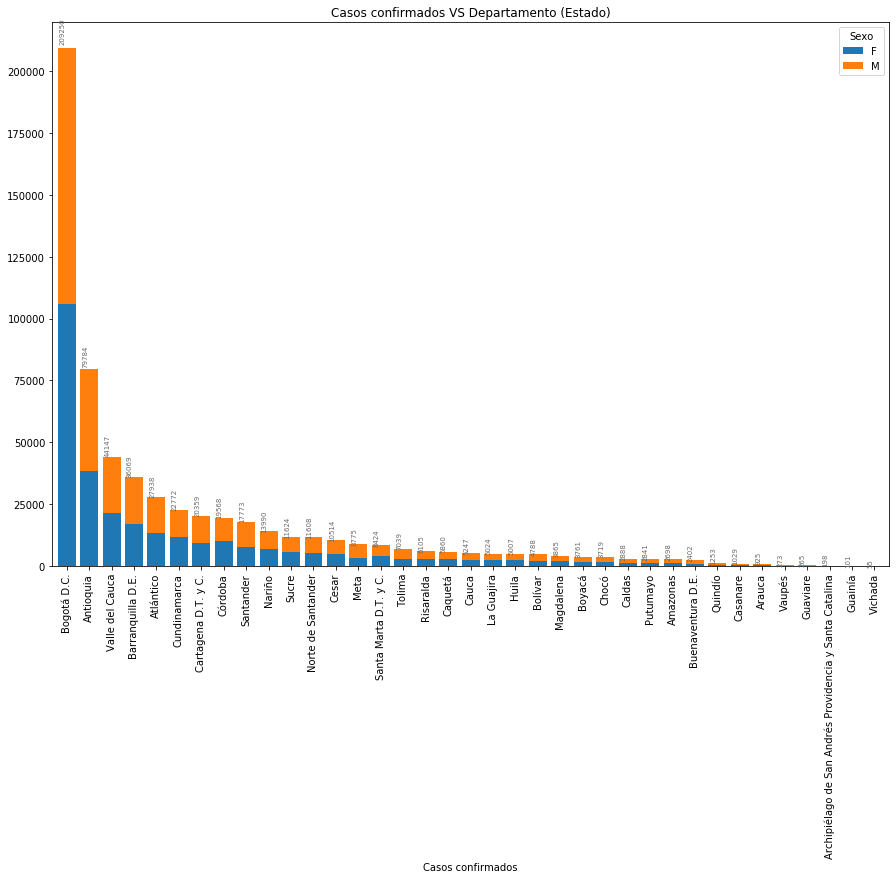

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         106086  103164  209250
Antioquia                                            38412   41372   79784
Valle del Cauca                                      21401   22746   44147
Barranquilla D.E.                                    17013   19056   36069
Atlántico                                            13242   14696   27938
Cundinamarca                                         11555   11217   22772
Cartagena D.T. y C.                                   9385   10974   20359
Córdoba                                              10067    9501   19568
Santander                                             7746   10027   17773
Nariño                                                6728    7262   13990
Sucre                                                 5630    5994   11624
Norte de Santander                                    5384    6224   11608
Cesar                                                 4918    5596   10514
Meta                                                  3353    5422    8775
Santa Marta D.T. y C.                                 4226    4198    8424
Tolima                                                2746    4293    7039
Risaralda                                             2938    3167    6105
Caquetá                                               2897    2963    5860
Cauca                                                 2489    2758    5247
La Guajira                                            2548    2476    5024
Huila                                                 2500    2507    5007
Bolívar                                               2230    2558    4788
Magdalena                                             1964    1901    3865
Boyacá                                                1745    2016    3761
Chocó                                                 1762    1957    3719
Caldas                                                1361    1527    2888
Putumayo                                              1295    1546    2841
Amazonas                                              1166    1532    2698
Buenaventura D.E.                                      900    1502    2402
Quindío                                                618     635    1253
Casanare                                               426     603    1029
Arauca                                                 306     619     925
Vaupés                                                 121     152     273
Guaviare                                                47     218     265
Archipiélago de San Andrés Providencia y Santa ...     114      84     198
Guainía                                                 41      60     101
Vichada                                                 15      40      55

### - Mapa de influencia COVID-19 (Colombia)

In [21]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

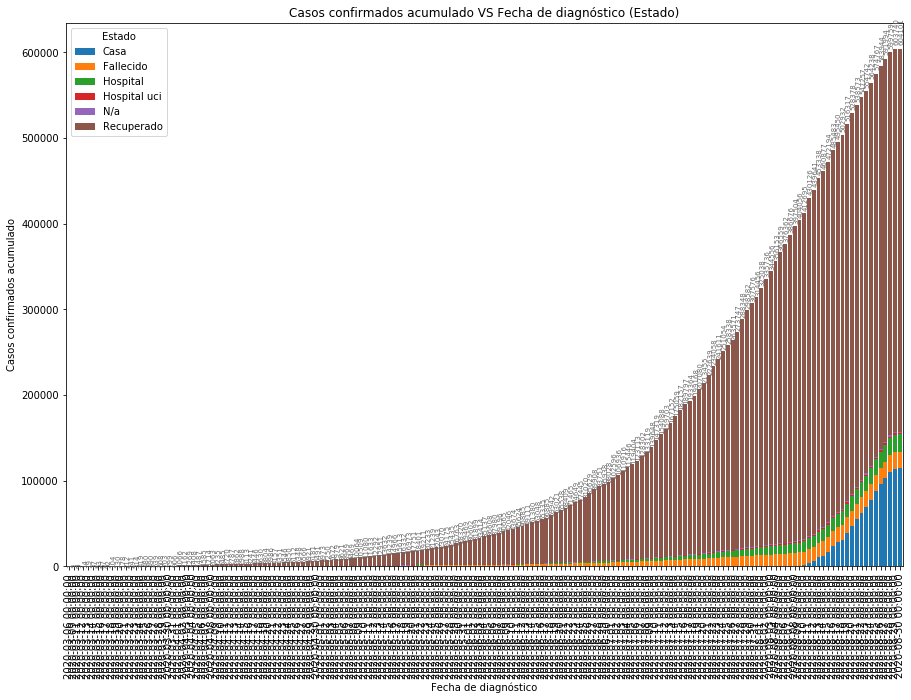

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-30            114373.0    19160.0   20358.0        1897.0  1227.0   
2020-08-29            114026.0    19160.0   20347.0        1894.0  1227.0   
2020-08-28            110334.0    19160.0   20068.0        1884.0  1227.0   
2020-08-27            103119.0    19119.0   19605.0        1840.0  1226.0   
2020-08-26             95699.0    19044.0   19118.0        1820.0  1224.0   
2020-08-25             87432.0    18925.0   18614.0        1798.0  1218.0   
2020-08-24             77597.0    18819.0   18175.0        1796.0  1211.0   
2020-08-23             68909.0    18685.0   17719.0        1786.0  1201.0   
2020-08-22             62050.0    18589.0   17407.0        1783.0  1198.0   
2020-08-21             54623.0    18428.0   16957.0        1776.0  1192.0   
2020-08-20             46795.0    18246.0   16477.0        1744.0  1180.0   
2020-08-19             39115.0    17944.0   15796.0        1686.0  1169.0   
2020-08-18             31022.0    17715.0   15260.0        1668.0  1156.0   
2020-08-17             28124.0    17497.0   14898.0        1659.0  1135.0   
2020-08-16             24025.0    17342.0   14577.0        1649.0  1127.0   
2020-08-15             17223.0    17076.0   14147.0        1640.0  1119.0   
2020-08-14             12549.0    16816.0   13698.0        1623.0  1110.0   
2020-08-13             10485.0    16594.0   13389.0        1611.0  1102.0   
2020-08-12              6091.0    16309.0   12908.0        1592.0  1088.0   
2020-08-11              4282.0    15981.0   12470.0        1569.0  1077.0   
2020-08-10              1541.0    15588.0   11829.0        1520.0  1060.0   
2020-08-09               835.0    15368.0   11495.0        1501.0  1043.0   
2020-08-08               345.0    15153.0   11182.0        1481.0  1036.0   
2020-08-07               102.0    14850.0   10891.0        1448.0  1022.0   
2020-08-06                61.0    14580.0   10564.0        1405.0  1004.0   
2020-08-05                50.0    14299.0   10298.0        1363.0   983.0   
2020-08-04                43.0    14018.0    9971.0        1320.0   961.0   
2020-08-03                37.0    13702.0    9660.0        1279.0   946.0   
2020-08-02                32.0    13374.0    9291.0        1245.0   927.0   
2020-08-01                31.0    13016.0    8908.0        1206.0   913.0   
2020-07-31                28.0    12675.0    8463.0        1173.0   893.0   
2020-07-30                26.0    12434.0    8214.0        1155.0   877.0   
2020-07-29                22.0    12141.0    7941.0        1113.0   857.0   
2020-07-28                20.0    11848.0    7616.0        1069.0   835.0   
2020-07-27                19.0    11298.0    7128.0        1018.0   796.0   
2020-07-26                16.0    10977.0    6842.0         982.0   774.0   
2020-07-25                16.0    10736.0    6654.0         958.0   761.0   
2020-07-24                16.0    10436.0    6358.0         924.0   744.0   
2020-07-23                16.0    10135.0    6087.0         894.0   723.0   
2020-07-22                16.0     9762.0    5752.0         856.0   694.0   
2020-07-21                13.0     9317.0    5344.0         806.0   667.0   
2020-07-20                11.0     8972.0    5088.0         756.0   652.0   
2020-07-19                11.0     8700.0    4812.0         728.0   640.0   
2020-07-18                11.0     8422.0    4598.0         704.0   623.0   
2020-07-17                11.0     8182.0    4428.0         676.0   601.0   
2020-07-16                11.0     8006.0    4327.0         662.0   592.0   
2020-07-15                10.0     7720.0    4076.0         624.0   572.0   
2020-07-14                10.0     7424.0    3874.0         591.0   561.0   
2020-07-13                10.0     7140.0    3658.0         563.0   535.0   
2020-07-12                10.0     6873.0    3426.0         532.0   514.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

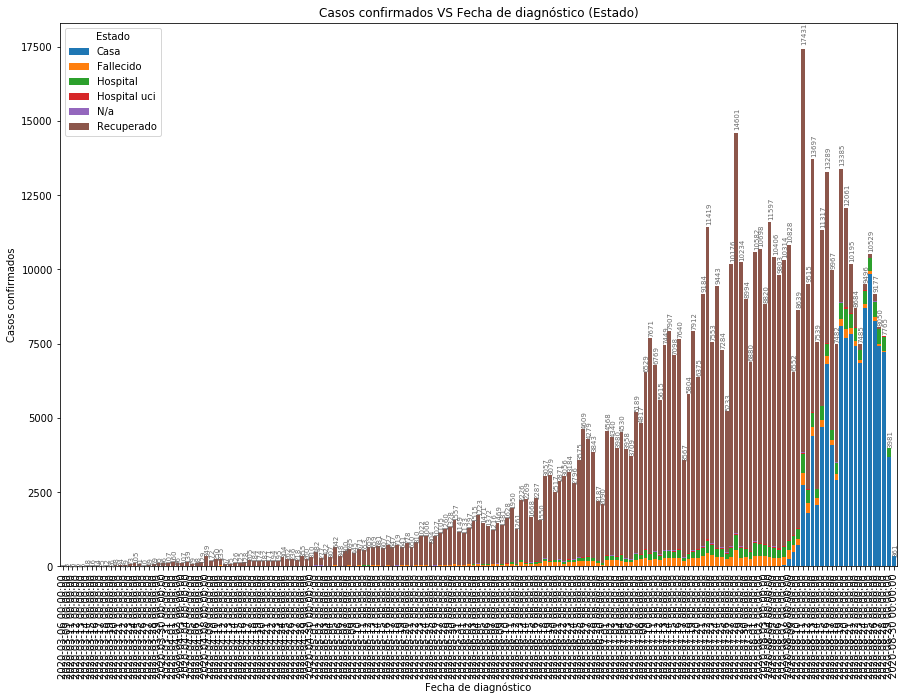

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-08-30             347.0        0.0      11.0           3.0   0.0   
2020-08-29            3692.0        0.0     279.0          10.0   0.0   
2020-08-28            7215.0       41.0     463.0          44.0   1.0   
2020-08-27            7420.0       75.0     487.0          20.0   2.0   
2020-08-26            8267.0      119.0     504.0          22.0   6.0   
2020-08-25            9835.0      106.0     439.0           2.0   7.0   
2020-08-24            8688.0      134.0     456.0          10.0  10.0   
2020-08-23            6859.0       96.0     312.0           3.0   3.0   
2020-08-22            7427.0      161.0     450.0           7.0   6.0   
2020-08-21            7828.0      182.0     480.0          32.0  12.0   
2020-08-20            7680.0      302.0     681.0          58.0  11.0   
2020-08-19            8093.0      229.0     536.0          18.0  13.0   
2020-08-18            2898.0      218.0     362.0           9.0  21.0   
2020-08-17            4099.0      155.0     321.0          10.0   8.0   
2020-08-16            6802.0      266.0     430.0           9.0   8.0   
2020-08-15            4674.0      260.0     449.0          17.0   9.0   
2020-08-14            2064.0      222.0     309.0          12.0   8.0   
2020-08-13            4394.0      285.0     481.0          19.0  14.0   
2020-08-12            1809.0      328.0     438.0          23.0  11.0   
2020-08-11            2741.0      393.0     641.0          49.0  17.0   
2020-08-10             706.0      220.0     334.0          19.0  17.0   
2020-08-09             490.0      215.0     313.0          20.0   7.0   
2020-08-08             243.0      303.0     291.0          33.0  14.0   
2020-08-07              41.0      270.0     327.0          43.0  18.0   
2020-08-06              11.0      281.0     266.0          42.0  21.0   
2020-08-05               7.0      281.0     327.0          43.0  22.0   
2020-08-04               6.0      316.0     311.0          41.0  15.0   
2020-08-03               5.0      328.0     369.0          34.0  19.0   
2020-08-02               1.0      358.0     383.0          39.0  14.0   
2020-08-01               3.0      341.0     445.0          33.0  20.0   
2020-07-31               2.0      241.0     249.0          18.0  16.0   
2020-07-30               4.0      293.0     273.0          42.0  20.0   
2020-07-29               2.0      293.0     325.0          44.0  22.0   
2020-07-28               1.0      550.0     488.0          51.0  39.0   
2020-07-27               3.0      321.0     286.0          36.0  22.0   
2020-07-26               0.0      241.0     188.0          24.0  13.0   
2020-07-25               0.0      300.0     296.0          34.0  17.0   
2020-07-24               0.0      301.0     271.0          30.0  21.0   
2020-07-23               0.0      373.0     335.0          38.0  29.0   
2020-07-22               3.0      445.0     408.0          50.0  27.0   
2020-07-21               2.0      345.0     256.0          50.0  15.0   
2020-07-20               0.0      272.0     276.0          28.0  12.0   
2020-07-19               0.0      278.0     214.0          24.0  17.0   
2020-07-18               0.0      240.0     170.0          28.0  22.0   
2020-07-17               0.0      176.0     101.0          14.0   9.0   
2020-07-16               1.0      286.0     251.0          38.0  20.0   
2020-07-15               0.0      296.0     202.0          33.0  11.0   
2020-07-14               0.0      284.0     216.0          28.0  26.0   
2020-07-13               0.0      267.0     232.0          31.0  21.0   
2020-07-12               0.0      212.0     151.0          28.0  14.0   
2020-07-11               1.0      260.0     206.0          19.0  27.0   
2020-07-10               0.0      219.0     191.0          28.0  18.0   
2020-07-09               0.0      293.0     241.0         

### - Casos confirmados VS Clasificación de edad (Estado)

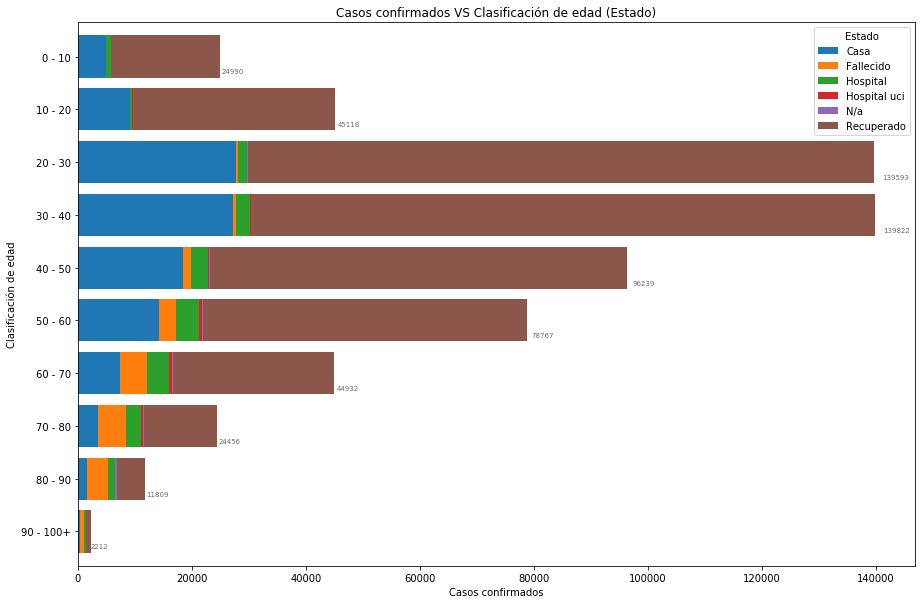

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  4894         34       873            50   32   
10 - 20                 9099         32       435            29   22   
20 - 30                27740        251      1662            83   54   
30 - 40                27137        634      2433           187   47   
40 - 50                18441       1408      2893           286   93   
50 - 60                14280       2914      4107           471  150   
60 - 70                 7437       4665      3881           447  258   
70 - 80                 3481       4947      2674           275  295   
80 - 90                 1556       3651      1273            73  239   
90 - 100+                311        828       187             7   61   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      19107  
10 - 20                     35501  
20 - 30                    109803  
30 - 40                    109384  
40 - 50                     73118  
50 - 60                     56845  
60 - 70                     28244  
70 - 80                     12784  
80 - 90                      5017  
90 - 100+                     818

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

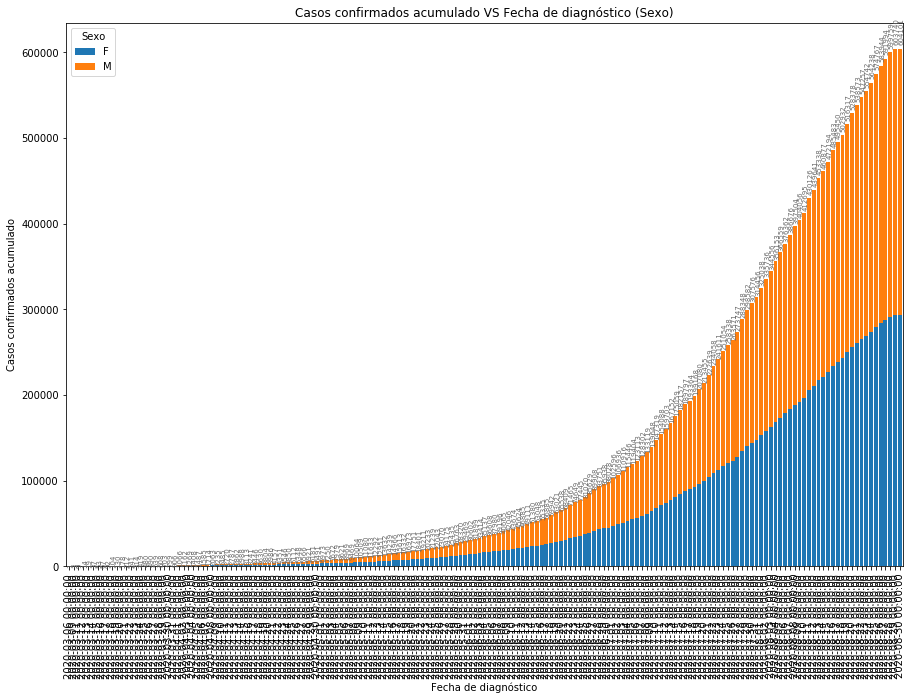

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-30            293560.0  310541.0
2020-08-29            293377.0  310363.0
2020-08-28            291333.0  308426.0
2020-08-27            287430.0  304564.0
2020-08-26            283374.0  300570.0
2020-08-25            278672.0  296095.0
2020-08-24            273375.0  290863.0
2020-08-23            268619.0  286123.0
2020-08-22            264811.0  282446.0
2020-08-21            260710.0  277863.0
2020-08-20            255568.0  272810.0
2020-08-19            249493.0  266824.0
2020-08-18            242543.0  260389.0
2020-08-17            238936.0  256514.0
2020-08-16            233666.0  251817.0
2020-08-15            226719.0  245475.0
2020-08-14            220968.0  239909.0
2020-08-13            217110.0  236228.0
2020-08-12            210252.0  229389.0
2020-08-11            205535.0  224591.0
2020-08-10            196502.0  216193.0
2020-08-09            192165.0  211891.0
2020-08-08            188788.0  208716.0
2020-08-07            183517.0  203159.0
2020-08-06            178478.0  197884.0
2020-08-05            173625.0  192934.0
2020-08-04            168414.0  187739.0
2020-08-03            162601.0  181955.0
2020-08-02            158333.0  177403.0
2020-08-01            152863.0  172175.0
2020-07-31            147743.0  166713.0
2020-07-30            144294.0  163282.0
2020-07-29            139921.0  158661.0
2020-07-28            134842.0  153506.0
2020-07-27            127730.0  146017.0
2020-07-26            122854.0  140717.0
2020-07-25            120456.0  137882.0
2020-07-24            116769.0  134285.0
2020-07-23            112403.0  129208.0
2020-07-22            108834.0  125224.0
2020-07-21            103670.0  118969.0
2020-07-20             99366.0  114089.0
2020-07-19             96390.0  110690.0
2020-07-18             92601.0  106567.0
2020-07-17             89820.0  103544.0
2020-07-16             88063.0  101734.0
2020-07-15             84314.0   97843.0
2020-07-14             80941.0   94118.0
2020-07-13             77345.0   89807.0
2020-07-12             73774.0   85929.0
2020-07-11             71100.0   82988.0
2020-07-10             67886.0   79433.0
2020-07-09             64382.0   75266.0
2020-07-08             61419.0   71700.0
2020-07-07             59109.0   69193.0
2020-07-06             56700.0   66413.0
2020-07-05             54947.0   64457.0
2020-07-04             53113.0   62333.0
2020-07-03             51084.0   59832.0
2020-07-02             49228.0   57708.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

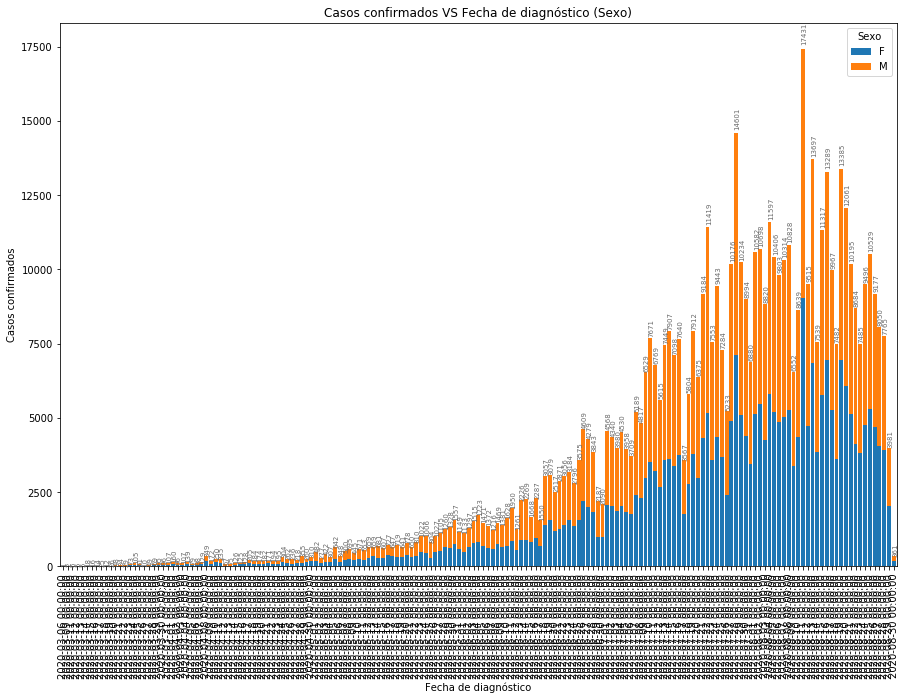

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-30             183.0   178.0
2020-08-29            2044.0  1937.0
2020-08-28            3903.0  3862.0
2020-08-27            4056.0  3994.0
2020-08-26            4702.0  4475.0
2020-08-25            5297.0  5232.0
2020-08-24            4756.0  4740.0
2020-08-23            3808.0  3677.0
2020-08-22            4101.0  4583.0
2020-08-21            5142.0  5053.0
2020-08-20            6075.0  5986.0
2020-08-19            6950.0  6435.0
2020-08-18            3607.0  3875.0
2020-08-17            5270.0  4697.0
2020-08-16            6947.0  6342.0
2020-08-15            5751.0  5566.0
2020-08-14            3858.0  3681.0
2020-08-13            6858.0  6839.0
2020-08-12            4717.0  4798.0
2020-08-11            9033.0  8398.0
2020-08-10            4337.0  4302.0
2020-08-09            3377.0  3175.0
2020-08-08            5271.0  5557.0
2020-08-07            5039.0  5275.0
2020-08-06            4853.0  4950.0
2020-08-05            5211.0  5195.0
2020-08-04            5813.0  5784.0
2020-08-03            4268.0  4552.0
2020-08-02            5470.0  5228.0
2020-08-01            5120.0  5462.0
2020-07-31            3449.0  3431.0
2020-07-30            4373.0  4621.0
2020-07-29            5079.0  5155.0
2020-07-28            7112.0  7489.0
2020-07-27            4876.0  5300.0
2020-07-26            2398.0  2835.0
2020-07-25            3687.0  3597.0
2020-07-24            4366.0  5077.0
2020-07-23            3569.0  3984.0
2020-07-22            5164.0  6255.0
2020-07-21            4304.0  4880.0
2020-07-20            2976.0  3399.0
2020-07-19            3789.0  4123.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3891.0
2020-07-15            3373.0  3725.0
2020-07-14            3596.0  4311.0
2020-07-13            3571.0  3878.0
2020-07-12            2674.0  2941.0
2020-07-11            3214.0  3555.0
2020-07-10            3504.0  4167.0
2020-07-09            2963.0  3566.0
2020-07-08            2310.0  2507.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2124.0
2020-07-02            2028.0  2312.0

### - Casos confirmados VS Clasificación de edad (Sexo)

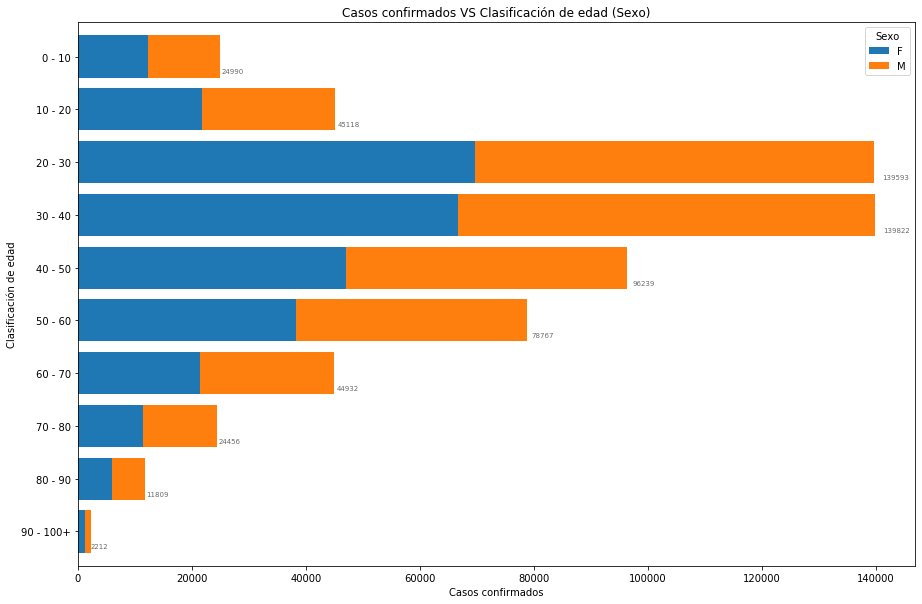

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 12239  12751
10 - 20                21742  23376
20 - 30                69559  70034
30 - 40                66586  73236
40 - 50                47087  49152
50 - 60                38161  40606
60 - 70                21327  23605
70 - 80                11415  13041
80 - 90                 6003   5806
90 - 100+               1256    956

### - Casos confirmados VS Estado (Sexo)

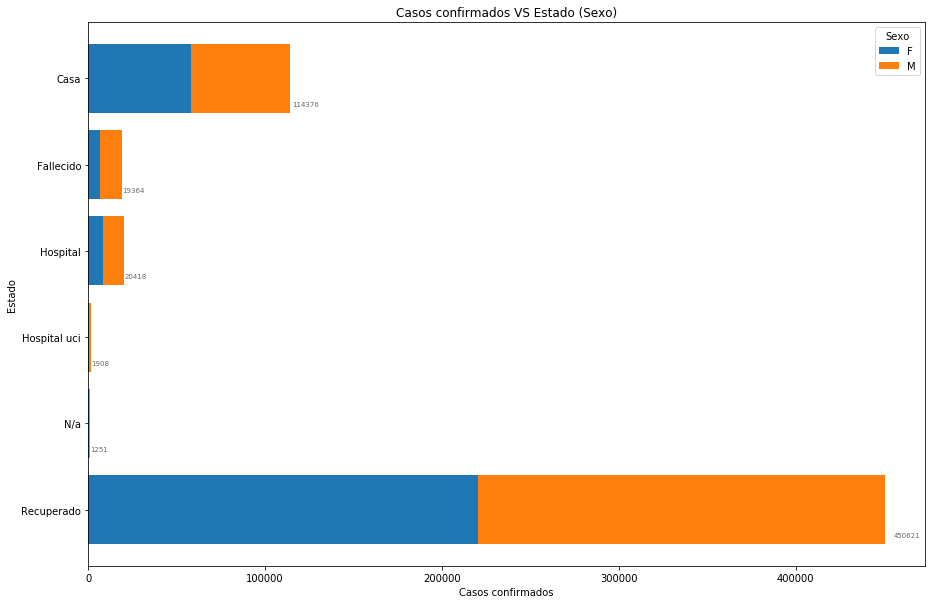

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           58354   56022
Fallecido       6933   12431
Hospital        8714   11704
Hospital uci     670    1238
N/a              543     708
Recuperado    220161  230460

### - Casos confirmados VS Tipo de contagio (Sexo)

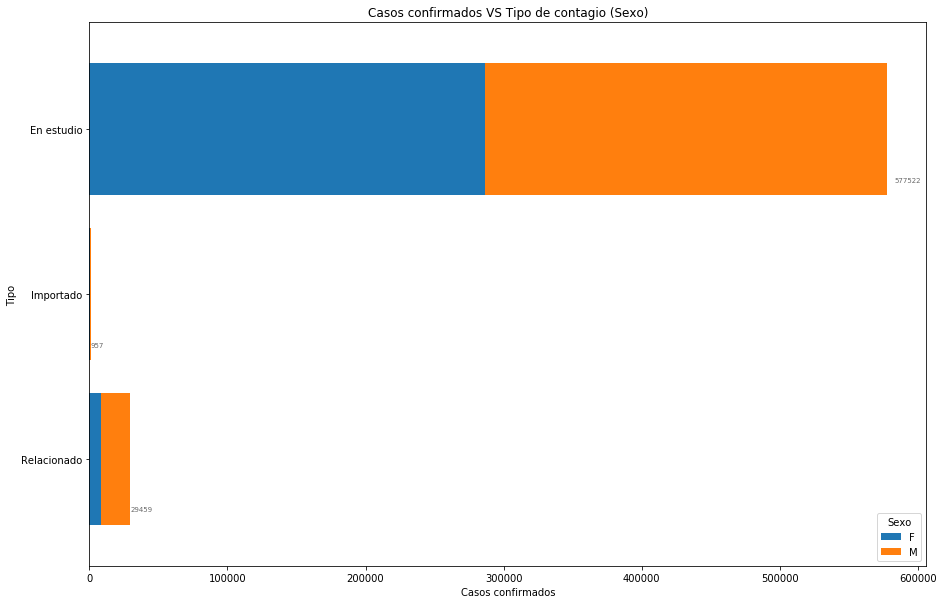

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   286840  290682
Importado       450     507
Relacionado    8085   21374

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

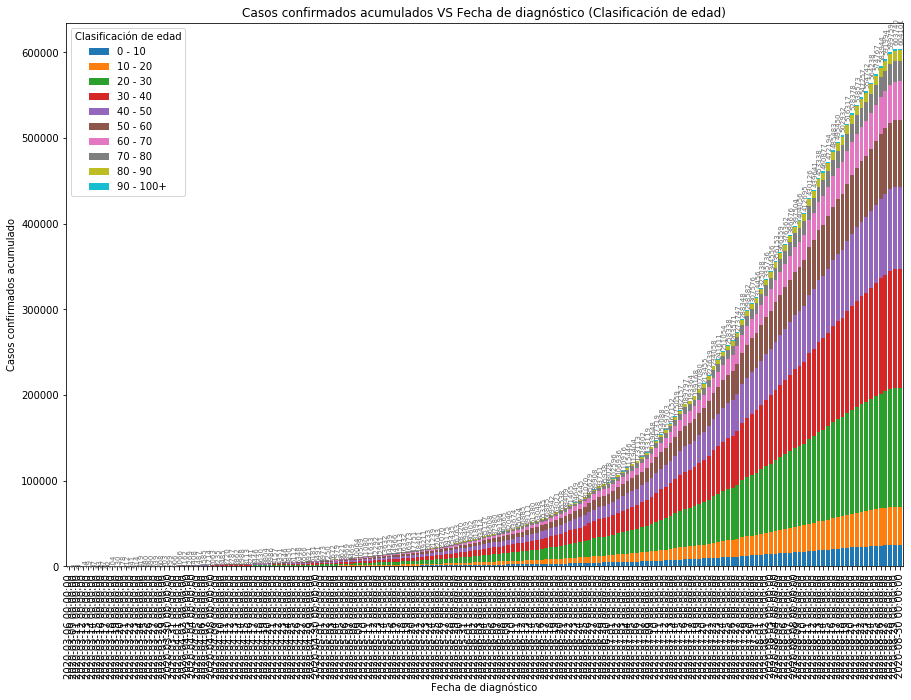

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-30              24855    44842   138684   138896    95674    78296   
2020-08-29              24842    44822   138581   138809    95619    78239   
2020-08-28              24678    44514   137681   137942    95017    77689   
2020-08-27              24388    43975   135969   136150    93803    76657   
2020-08-26              24063    43394   134114   134313    92513    75641   
2020-08-25              23724    42698   132157   132223    91037    74488   
2020-08-24              23345    42013   129755   129756    89326    73085   
2020-08-23              22987    41310   127550   127620    87841    71857   
2020-08-22              22679    40703   125751   125875    86731    70873   
2020-08-21              22362    40049   123749   123809    85425    69774   
2020-08-20              21944    39312   121321   121496    83811    68440   
2020-08-19              21460    38459   118673   118788    81896    66831   
2020-08-18              20832    37481   115667   115789    79700    65136   
2020-08-17              20580    36969   114003   114099    78503    64113   
2020-08-16              20066    36209   111796   112002    76912    62779   
2020-08-15              19448    35074   108838   109107    74796    61033   
2020-08-14              18948    34236   106231   106608    73014    59510   
2020-08-13              18694    33698   104497   104933    71794    58453   
2020-08-12              18071    32634   101399   101830    69606    56648   
2020-08-11              17724    32000    99317    99627    68093    55386   
2020-08-10              16930    30749    95205    95593    65258    53137   
2020-08-09              16599    30068    93254    93588    63904    52021   
2020-08-08              16355    29641    91746    92159    62822    51139   
2020-08-07              15939    28857    89309    89518    61116    49718   
2020-08-06              15525    28086    86949    87085    59478    48382   
2020-08-05              15076    27341    84770    84845    57909    47108   
2020-08-04              14649    26615    82386    82437    56220    45743   
2020-08-03              14160    25797    79728    79726    54317    44159   
2020-08-02              13836    25188    77729    77676    52970    42941   
2020-08-01              13393    24468    75318    75281    51163    41440   
2020-07-31              12979    23613    72763    72772    49542    40097   
2020-07-30              12706    23156    71233    71135    48367    39248   
2020-07-29              12362    22443    69051    69003    47040    38072   
2020-07-28              11980    21697    66625    66529    45354    36827   
2020-07-27              11351    20561    63298    63241    43037    34894   
2020-07-26              10965    19839    60910    60856    41367    33681   
2020-07-25              10755    19514    59721    59629    40553    33000   
2020-07-24              10471    19030    58084    57925    39387    32010   
2020-07-23              10150    18309    55879    55636    37910    30776   
2020-07-22               9873    17793    54195    53888    36709    29786   
2020-07-21               9467    16945    51473    51299    34923    28241   
2020-07-20               9107    16318    49308    49118    33439    27089   
2020-07-19               8829    15858    47953    47658    32369    26260   
2020-07-18               8516    15198    46119    45802    31059    25278   
2020-07-17               8294    14856    44825    44386    30102    24526   
2020-07-16               8171    14637    44023    43525    29555    24072   
2020-07-15               7829    14126    42310    41712    28302    23050   
2020-07-14               7534    13589    40700    40097    27171    22115   
2020-07-13               7238    13005    38832    38218    25894    21139   
2020-07-12            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

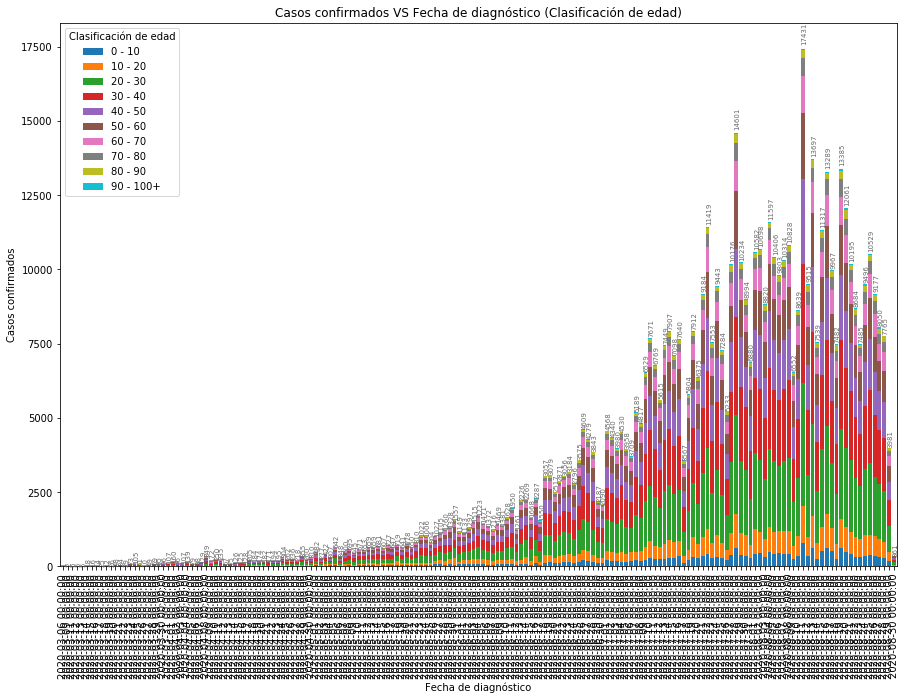

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-30                 13       20      103       87       55       57   
2020-08-29                164      308      900      867      602      550   
2020-08-28                290      539     1712     1792     1214     1032   
2020-08-27                325      581     1855     1837     1290     1016   
2020-08-26                339      696     1957     2090     1476     1153   
2020-08-25                379      685     2402     2467     1711     1403   
2020-08-24                358      703     2205     2136     1485     1228   
2020-08-23                308      607     1799     1745     1110      984   
2020-08-22                317      654     2002     2066     1306     1099   
2020-08-21                418      737     2428     2313     1614     1334   
2020-08-20                484      853     2648     2708     1915     1609   
2020-08-19                628      978     3006     2999     2196     1695   
2020-08-18                252      512     1664     1690     1197     1023   
2020-08-17                514      760     2207     2097     1591     1334   
2020-08-16                618     1135     2958     2895     2116     1746   
2020-08-15                500      838     2607     2499     1782     1523   
2020-08-14                254      538     1734     1675     1220     1057   
2020-08-13                623     1064     3098     3103     2188     1805   
2020-08-12                347      634     2082     2203     1513     1262   
2020-08-11                794     1251     4112     4034     2835     2249   
2020-08-10                331      681     1951     2005     1354     1116   
2020-08-09                244      427     1508     1429     1082      882   
2020-08-08                416      784     2437     2641     1706     1421   
2020-08-07                414      771     2360     2433     1638     1336   
2020-08-06                449      745     2179     2240     1569     1274   
2020-08-05                427      726     2384     2408     1689     1365   
2020-08-04                489      818     2658     2711     1903     1584   
2020-08-03                324      609     1999     2050     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      855     2555     2509     1621     1343   
2020-07-31                273      457     1530     1637     1175      849   
2020-07-30                344      713     2182     2132     1327     1176   
2020-07-29                382      746     2426     2474     1686     1245   
2020-07-28                629     1136     3327     3288     2317     1933   
2020-07-27                386      722     2388     2385     1670     1213   
2020-07-26                210      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      990   
2020-07-24                321      721     2205     2289     1477     1234   
2020-07-23                277      516     1684     1748     1201      990   
2020-07-22                406      848     2722     2589     1786     1545   
2020-07-21                360      627     2165     2181     1484     1152   
2020-07-20                278      460     1355     1460     1070      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      511     1713     1813     1253     1022   
2020-07-15                295      537     1610     1615     1131      935   
2020-07-14                296      584     1868     1879     1277      976   
2020-07-13                255      489     1784     1716     1214      988   
2020-07-12            

### - Casos confirmados VS Estado (Clasificación de edad)

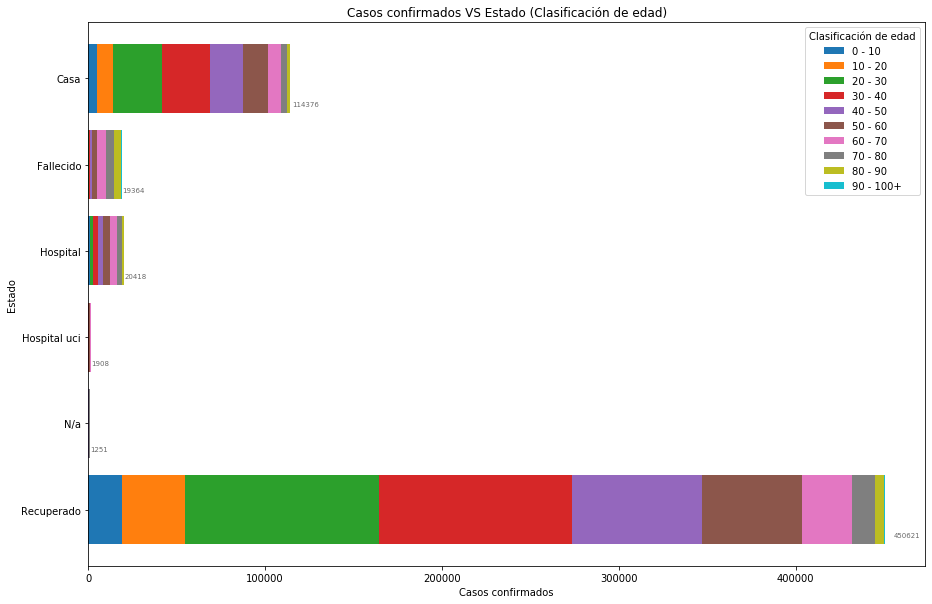

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     4894     9099    27740    27137    18441    14280   
Fallecido                  34       32      251      634     1408     2914   
Hospital                  873      435     1662     2433     2893     4107   
Hospital uci               50       29       83      187      286      471   
N/a                        32       22       54       47       93      150   
Recuperado              19107    35501   109803   109384    73118    56845   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7437     3481     1556        311  
Fallecido                 4665     4947     3651        828  
Hospital                  3881     2674     1273        187  
Hospital uci               447      275       73          7  
N/a                        258      295      239         61  
Recuperado               28244    12784     5017        818

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

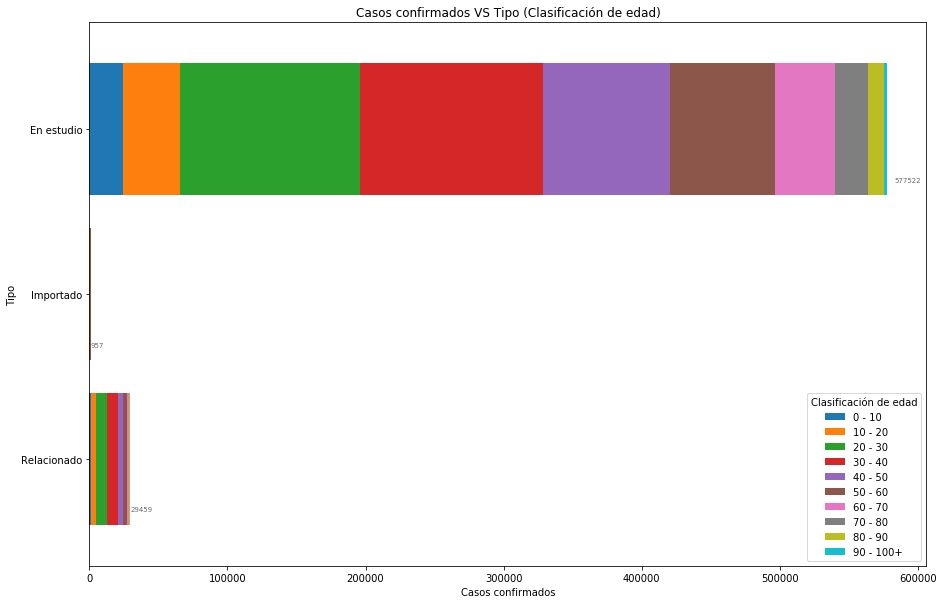

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              23993    41350   131007   131969    92315    76059   
Importado                   5       37      239      222      169      144   
Relacionado               992     3731     8347     7631     3755     2564   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               43508    23818    11392       2111  
Importado                   95       36        9          1  
Relacionado               1329      602      408        100

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>